In [3]:
#
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import time
import os

from pfbase_ali_mod import *
from ufl import split, dx, ds, inner, grad, variable, diff

save_solution = True

In [2]:

###################################
# Optimization options for the finite element form compiler
###################################
df.parameters["form_compiler"]["cpp_optimize"] = True
df.parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math'
df.parameters["form_compiler"]["quadrature_degree"] = 3

###################################
# Create or read mesh
###################################
Lx = 25.
Ly = 1.
Nx = 250
Ny = 10
mesh = df.RectangleMesh(df.Point(0.0, 0.0), df.Point(Lx, Ly), Nx, Ny, 'crossed')



In [3]:
P1 = df.FunctionSpace(mesh, 'P', 1)
PE = P1.ufl_element()
ME = [PE, PE]
ME = df.MixedElement(ME)
W  = df.FunctionSpace(mesh,  ME)

w  = df.Function(W)
dw = df.TrialFunction(W)
w_ = df.TestFunction(W)

In [4]:
ux, uy = df.split(w)
ux = df.variable(ux)
uy = df.variable(uy)


#dux, duy = df.split(dw)
#dux = df.variable(dux)
#duy = df.variable(duy)

In [5]:
# this function returns the total strain tensor components
# vx = x component of the displacement vector, vy = y component of the displacement
def eps(vx, vy):
    duxdx, duxdy = df.grad(vx)
    duydx, duydy = df.grad(vy)
    eps_xx = duxdx
    eps_xy = 0.5*(duxdy+duydx) # eps_yx = eps_xy
    eps_yy = duydy
    return eps_xx, eps_xy, eps_yy 

#plane stress case

E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)

#loading condition
rho_g = 1e-3
f = df.Constant((0, -rho_g))


def sigma(vx, vy, mu_0 = mu, lmbda_0 = lmbda):
    eps_xx, eps_xy, eps_yy = eps(vx, vy)
    
    
    sigma_xx = lmbda_0*(eps_xx+eps_yy) + 2*mu_0*eps_xx
    sigma_xy = 2*mu_0*eps_xy                # sigma_yx = sigma_xy
    sigma_yy = lmbda_0*(eps_xx+eps_yy) + 2*mu_0*eps_yy
    
    return sigma_xx, sigma_xy, sigma_yy

In [6]:
eps_xx, eps_xy, eps_yy = eps(ux, uy)
sigma_xx, sigma_xy, sigma_yy = sigma(ux, uy, mu, lmbda)
#sigma_xx_x, sigma_xx_y = df.grad(sigma_xx)
#sigma_xy_x, sigma_xy_y = df.grad(sigma_xy)
#sigma_yy_x, sigma_yy_y = df.grad(sigma_yy)


a_x = w_[0]*(sigma_xx*eps_xx+sigma_xy*eps_xy)*dx
l_x = 0

a_y =  w_[1]*(sigma_xy*eps_xy+sigma_yy*eps_yy)*dx

l_y = w_[1]*df.Constant(-rho_g)*dx



In [7]:
def left(x, on_boundary):
    return near(x[0], 0.)

bc = DirichletBC(W, Constant((0.,0.)), left)

In [8]:
def F_ux_weak_form(vx_, vy_, vx, vy, fx, mu_0 = mu, lmbda_0 = lmbda):
    eps_xx, eps_xy, eps_yy = eps(vx_, vy_)
    sigma_xx, sigma_xy, sigma_yy = sigma(vx, vy, mu_0, lmbda_0)
    lhs = (sigma_xx*eps_xx+sigma_xy*eps_xy)*dx
    rhs = vx_*fx*dx

    F = lhs - rhs

    return F

def F_uy_weak_form(vx_, vy_, vx, vy, fy, mu_0 = mu, lmbda_0 = lmbda):
    eps_xx, eps_xy, eps_yy = eps(vx_, vy_)
    sigma_xx, sigma_xy, sigma_yy = sigma(vx, vy, mu_0, lmbda_0)

    lhs =  (sigma_xy*eps_xy+sigma_yy*eps_yy)*dx
    rhs = vy_*fy*dx

    F = lhs - rhs

    return F

def F_u_weak_form_tot(vx_, vy_, vx, vy, fx, fy, mu_0 = mu, lmbda_0 = lmbda):
    eps_xx, eps_xy, eps_yy = eps(vx_, vy_)
    sigma_xx, sigma_xy, sigma_yy = sigma(vx, vy, mu_0, lmbda_0)

    lhs = (sigma_xx*eps_xx+sigma_xy*eps_xy+sigma_xy*eps_xy+sigma_yy*eps_yy)*dx
    rhs = (vx_*fx+vy_*fy)*dx

    F = lhs  - rhs

    return F


In [9]:
#F_mx = F_ux_weak_form(w_[0], w_[1], w[0], w[1], f[0])
#F_my = F_ux_weak_form(w_[0], w_[1], w[0], w[1], f[1])
#F = F_mx + F_my

F = F_u_weak_form_tot(w_[0], w_[1], w[0], w[1], f[0], f[1])

Wux, Wuy = W.split()

In [10]:
tol = 1E-12
def boundary_left(x, on_boundary):
    return on_boundary and df.near(x[0], 0, tol)

bc_ux_left  = df.DirichletBC(Wux, df.Constant(0.0), boundary_left)
bc_uy_left  = df.DirichletBC(Wuy, df.Constant(0.0), boundary_left)



bcs = [bc_ux_left, bc_uy_left]  # no-flux on top, bottom boundary

###############
J = df.derivative(F, w, dw)



In [11]:

###################################
# Nonlinear solver setup
###################################
#df.set_log_level(df.LogLevel.ERROR)

problem = df.NonlinearVariationalProblem(F, w, bcs, J)
solver  = df.NonlinearVariationalSolver(problem)

#solver.parameters['nonlinear_solver'] = 'newton'
#nlparams  = solver.parameters['newton_solver']

solver.parameters['nonlinear_solver'] = 'snes'
nlparams  = solver.parameters['snes_solver']



nlparams['report'] = True
nlparams['error_on_nonconvergence'] = False
nlparams['absolute_tolerance'] = 1e-6
nlparams['maximum_iterations'] = 30

#
# bactracig (bt) diverges with only Laplace eqn
#nlparams['line_search'] = 'bt'      # WORKS (7s) for np=32, T=3.0
nlparams['line_search'] = 'cp'       # (8s) #
#nlparams['line_search'] = 'basic'   # (7s)
#nlparams['line_search'] = 'nleqerr' # (15s)
#nlparams['line_search'] = 'l2'      # FAILING

# 
nlparams['linear_solver'] = 'gmres'
nlparams['preconditioner'] = 'hypre_amg'

#nlparams['linear_solver'] = 'gmres'
#nlparams['linear_solver'] = 'bicgstab'
#nlparams['linear_solver'] = 'minres'

#nlparams['preconditioner'] = 'none'
#nlparams['preconditioner'] = 'sor'
#nlparams['preconditioner'] = 'petsc_amg'
#nlparams['preconditioner'] = 'hypre_amg'

nlparams['krylov_solver']['maximum_iterations'] = 5000
nlparams['krylov_solver']['monitor_convergence'] = True


In [12]:
# solve
print('start')
niters, converged = solver.solve()

start
Solving nonlinear variational problem.
  0 SNES Function norm 3.647145002144e-04 
    0 KSP preconditioned resid norm 4.294925341043e-04 true resid norm 3.647145002144e-04 ||r(i)||/||b|| 1.000000000000e+00
    1 KSP preconditioned resid norm 1.223094979734e-04 true resid norm 8.483044012576e-02 ||r(i)||/||b|| 2.325940977830e+02
    2 KSP preconditioned resid norm 8.676538224237e-05 true resid norm 2.690175687152e-01 ||r(i)||/||b|| 7.376113879679e+02
    3 KSP preconditioned resid norm 5.391904889003e-05 true resid norm 2.609954211100e-01 ||r(i)||/||b|| 7.156156965421e+02
    4 KSP preconditioned resid norm 5.307224443849e-05 true resid norm 2.809660530277e-01 ||r(i)||/||b|| 7.703725869482e+02
    5 KSP preconditioned resid norm 4.851472878443e-05 true resid norm 4.451903685656e-01 ||r(i)||/||b|| 1.220654425047e+03
    6 KSP preconditioned resid norm 4.840830596844e-05 true resid norm 5.476080305961e-01 ||r(i)||/||b|| 1.501470411168e+03
    7 KSP preconditioned resid norm 4.513286

In [13]:
print(niters)
print(converged)

2
True


In [14]:
ux, uy = w.split()

Object cannot be plotted directly, projecting to piecewise linears.


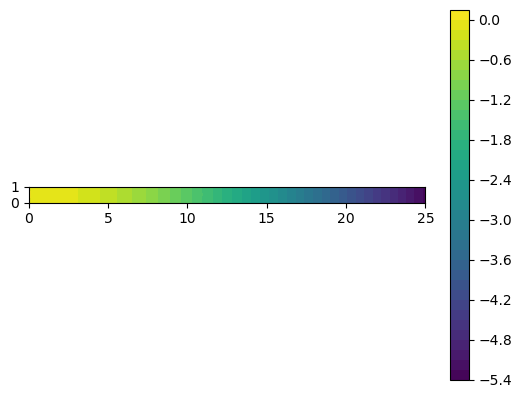

In [15]:
c = plot(uy*1e3)
plt.colorbar(c)